In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [5]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [6]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Subset_Style_Model.pt'))

<All keys matched successfully>

In [7]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [02:44<00:00, 64.78it/s]


## Centroids

In [8]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [9]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.301,0.260,0.541,0.264,0.371,0.337
1,0.000,0.000,0.311,0.532,0.323,0.396,0.338
2,0.000,0.000,0.000,0.530,0.217,0.268,0.257
3,0.000,0.000,0.000,0.000,0.553,0.584,0.536
4,0.000,0.000,0.000,0.000,0.000,0.294,0.215
5,0.000,0.000,0.000,0.000,0.000,0.000,0.216
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

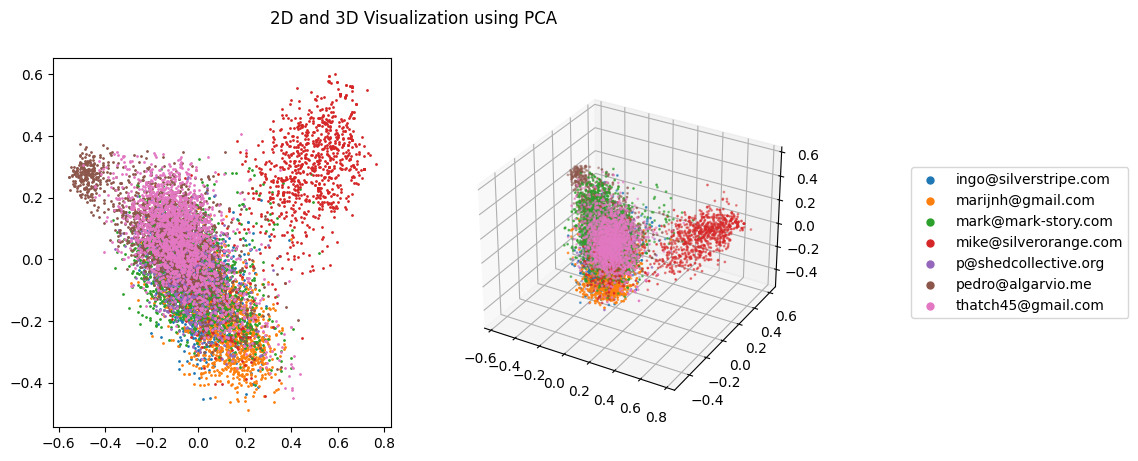

In [10]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

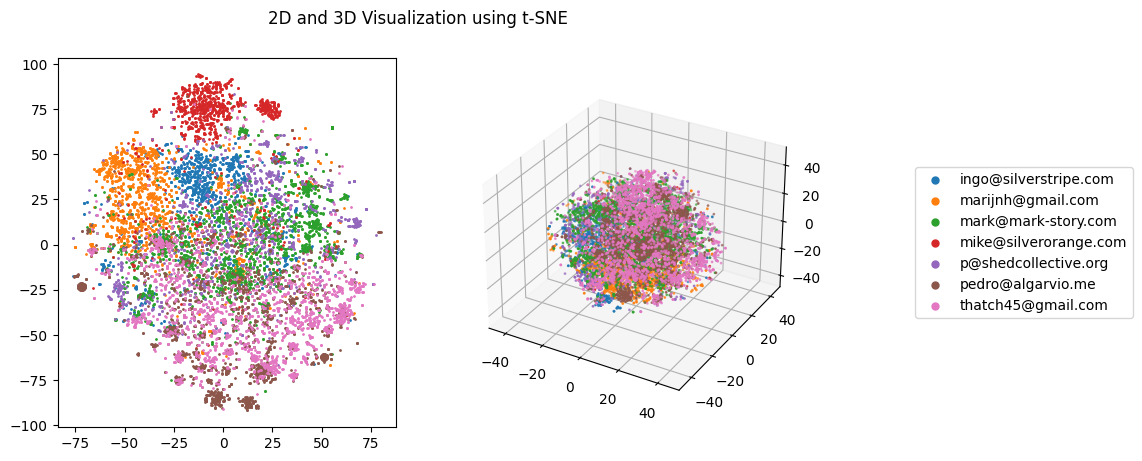

In [11]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 4
10 Most common:
[(-1, 7829), (0, 2668), (1, 101), (2, 86)]


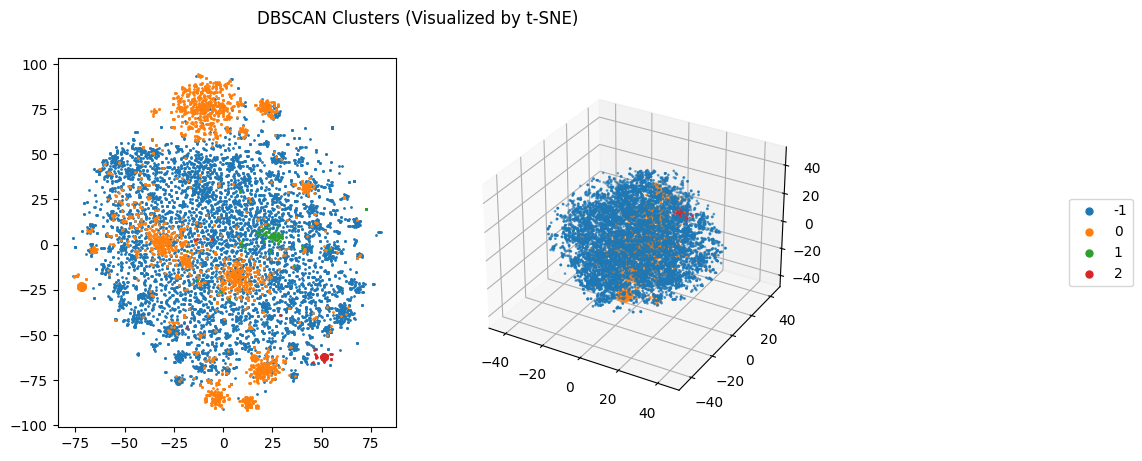

In [12]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [13]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

KeyError: 'Median number of commits per different Author'

In [14]:
dbscan_summary.describe()

NameError: name 'dbscan_summary' is not defined

In [15]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

NameError: name 'i' is not defined

In [ ]:
print_clustering_classes(dbscan_prediction, test_data)

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(4, 3040), (5, 2600), (3, 1439), (2, 1394), (0, 885), (6, 870), (1, 456)]


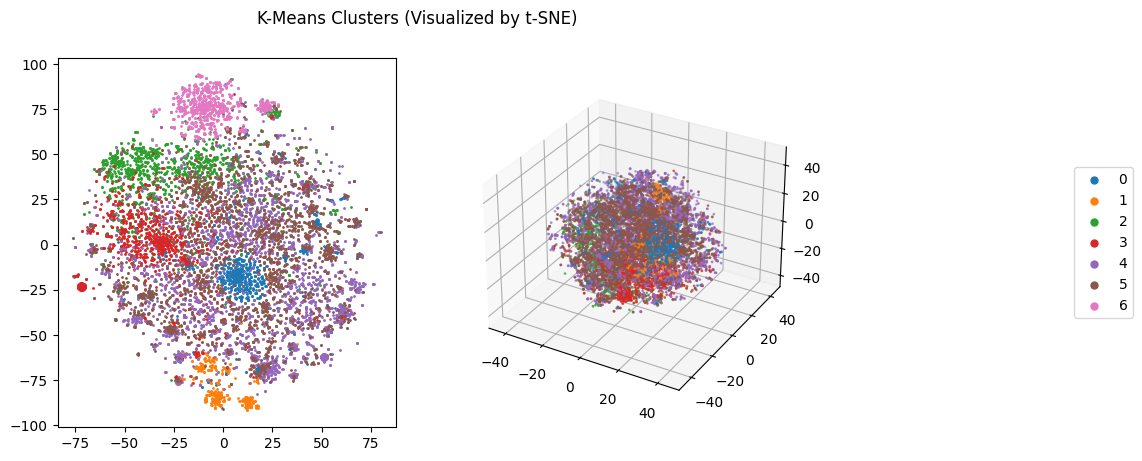

In [16]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [ ]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

In [ ]:
kmeans_summary.describe()

In [ ]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

In [ ]:
print_clustering_classes(kmeans_prediction, test_data)